<a href="https://colab.research.google.com/github/yassminyasser491-cyber/Teeth-Classification/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
import zipfile

# This line triggers the file picker UI in Colab
uploaded = files.upload()

# Extract the name of the uploaded zip file
zip_filename = next(iter(uploaded.keys()))

# Extract the uploaded zip into a folder named 'dataset'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('dataset')

print(f"Uploaded and extracted: {zip_filename}")


Saving data-20250920T095458Z-1-001.zip to data-20250920T095458Z-1-001 (1).zip
Uploaded and extracted: data-20250920T095458Z-1-001 (1).zip


In [5]:
import tifffile as tiff
import numpy as np
from PIL import Image
import os

# Adjust these to your structure:
image_dir = 'dataset/data/images'
mask_dir = 'dataset/data/labels'

# Match up images and masks by their numeric part before the extension
def extract_id(filename):
    return filename.split('.')[0]  # Gets '86' from '86.tif', etc.

# Get all image and mask ids (as strings)
image_ids = {extract_id(f) for f in os.listdir(image_dir)}
mask_ids = {extract_id(f) for f in os.listdir(mask_dir)}

# Only keep image ids that have a corresponding mask
common_ids = sorted(list(image_ids & mask_ids))

# Prepare arrays
X_list, Y_list = [], []

for img_id in common_ids:
    img_path = os.path.join(image_dir, img_id + '.tif')
    mask_path = None
    # Try .png first
    if os.path.exists(os.path.join(mask_dir, img_id + '.png')):
        mask_path = os.path.join(mask_dir, img_id + '.png')
    elif os.path.exists(os.path.join(mask_dir, img_id + '.tif')):
        mask_path = os.path.join(mask_dir, img_id + '.tif')
    else:
        continue  # No valid mask file, skip

    # Read image
    img = tiff.imread(img_path).astype(np.float32)  # shape: (128,128,12)
    # Read mask
    mask = np.array(Image.open(mask_path))
    # Binzarize
    mask = (mask > 0).astype(np.uint8)
    # Append to list
    X_list.append(img)
    Y_list.append(mask)

X = np.stack(X_list)  # shape: (N,128,128,12)
Y = np.stack(Y_list)  # shape: (N,128,128)

# Normalization - per-band min-max
X_norm = np.zeros_like(X, dtype=np.float32)
for i in range(X.shape[-1]):
    band = X[...,i]
    band_min = band.min()
    band_max = band.max()
    X_norm[...,i] = (band - band_min) / (band_max - band_min + 1e-8)


In [6]:



# 5. Normalization (per-band min-max normalization across dataset)
X_norm = np.zeros_like(X, dtype=np.float32)
for i in range(X.shape[-1]):
    band = X[...,i]
    band_min = band.min()
    band_max = band.max()
    X_norm[...,i] = (band - band_min) / (band_max - band_min + 1e-8)



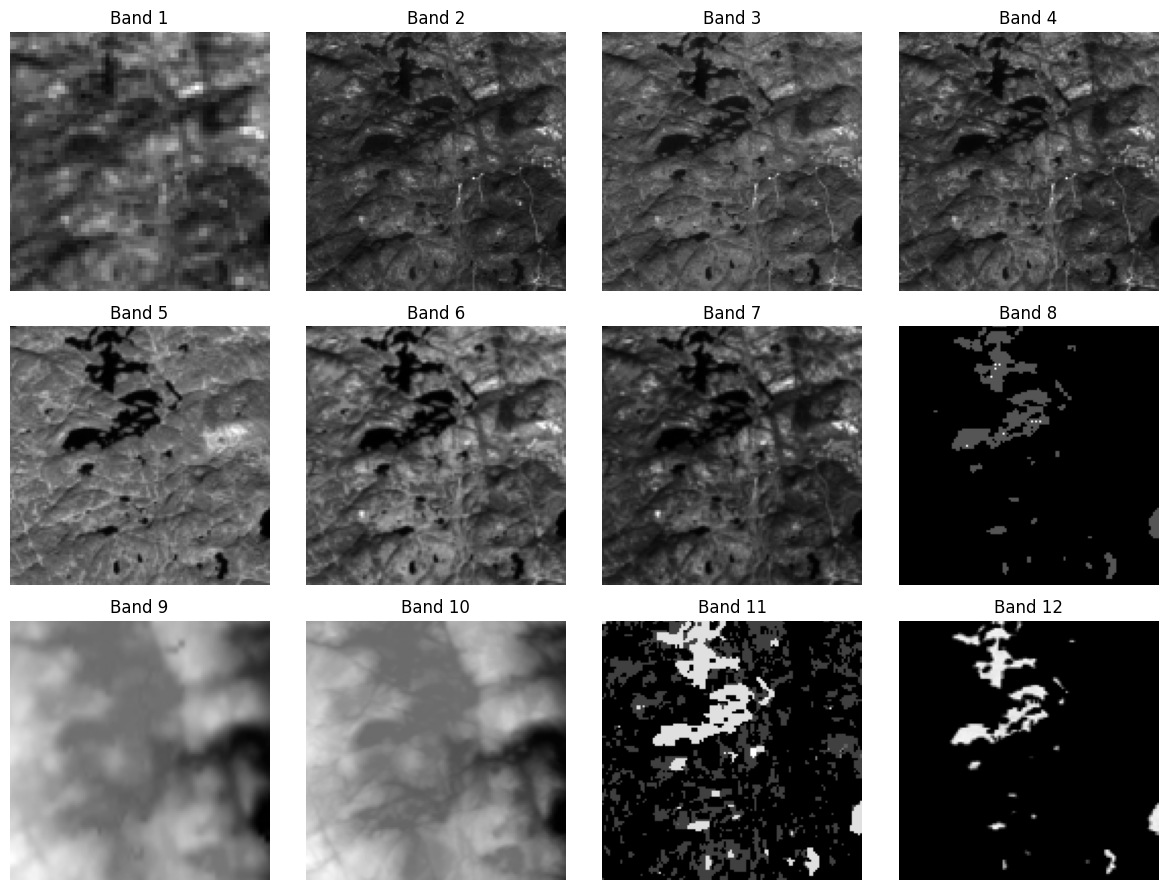

In [7]:
# 6. Visualization: Plot each band of the first image
fig, axs = plt.subplots(3,4, figsize=(12,9))
for i in range(12):
    ax = axs[i//4, i%4]
    ax.imshow(X_norm[0,...,i], cmap='gray')
    ax.set_title(f'Band {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# 7. Data splits
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.2, random_state=42)




In [8]:
# 8. U-Net Architecture
def unet_model(input_shape):
    inputs = Input(input_shape)
    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D()(c4)
    # Bottleneck
    c5 = Conv2D(512, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)
    # Decoder
    u6 = Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)
    u7 = Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)
    u8 = Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(64, 3, activation='relu', padding='same')(c8)
    u9 = Conv2DTranspose(32, 2, strides=2, padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(32, 3, activation='relu', padding='same')(c9)
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)
    model = Model(inputs, outputs)
    return model

model = unet_model((128,128,12))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [14]:
# 9. Model Training
history = model.fit(
    X_train, Y_train[...,np.newaxis],
    validation_split=0.1,
    epochs=20,
    batch_size=8
)



Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8869 - loss: 0.2920 - val_accuracy: 0.9285 - val_loss: 0.2002
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8726 - loss: 0.3325 - val_accuracy: 0.9300 - val_loss: 0.2036
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9032 - loss: 0.2548 - val_accuracy: 0.9344 - val_loss: 0.2013
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8960 - loss: 0.2656 - val_accuracy: 0.9393 - val_loss: 0.1853
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9084 - loss: 0.2391 - val_accuracy: 0.9399 - val_loss: 0.1824
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8962 - loss: 0.2646 - val_accuracy: 0.9397 - val_loss: 0.1890
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8895 - loss: 0.2729 - val_accuracy: 0.9418 - val_loss: 0.1841
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9010 - loss: 0.2561 - val_accuracy: 0.9385 - v

In [13]:
# 10. Evaluation: IoU, Precision, Recall, F1 (for water class)
Y_pred = model.predict(X_test)
Y_pred_bin = (Y_pred[...,0] > 0.5).astype(np.uint8)

flat_true = Y_test.flatten()
flat_pred = Y_pred_bin.flatten()

iou = jaccard_score(flat_true, flat_pred)
precision = precision_score(flat_true, flat_pred)
recall = recall_score(flat_true, flat_pred)
f1 = f1_score(flat_true, flat_pred)

print(f"IoU: {iou:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
IoU: 0.619
Precision: 0.951
Recall: 0.639
F1 Score: 0.765


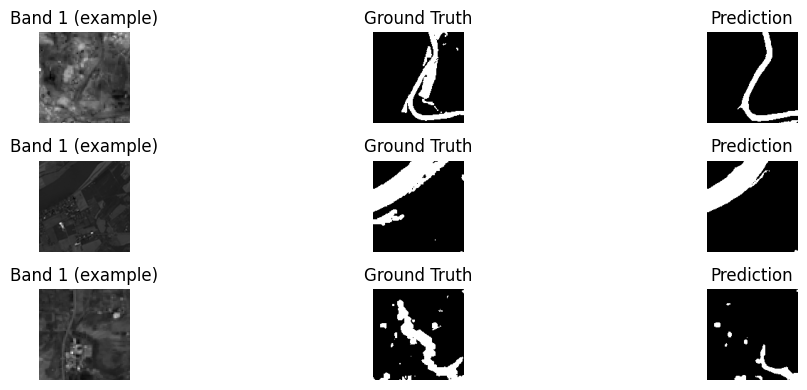

In [11]:
# 11. Visualize Results
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3,3,3*i + 1)
    plt.imshow(X_test[i][...,0], cmap='gray')
    plt.title('Band 1 (example)')
    plt.axis('off')
    plt.subplot(3,3,3*i + 2)
    plt.imshow(Y_test[i], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(3,3,3*i + 3)
    plt.imshow(Y_pred_bin[i], cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
plt.tight_layout()
plt.show()